In [59]:
import os,subprocess,shutil,glob,copy
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from astropy.io import ascii
from reproject import reproject_exact
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt

In [36]:
#fitsfile = "20220225_i1_al.fits"
fitsfile = "new-image.fits"
wcsfile = "wcs.fits"
cutout = "20220225_i1_al_cutout.fits"
w = WCS(wcsfile)
h = fits.getheader(fitsfile)
data = fits.getdata(fitsfile)


/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.py:532: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  warnings.warn(


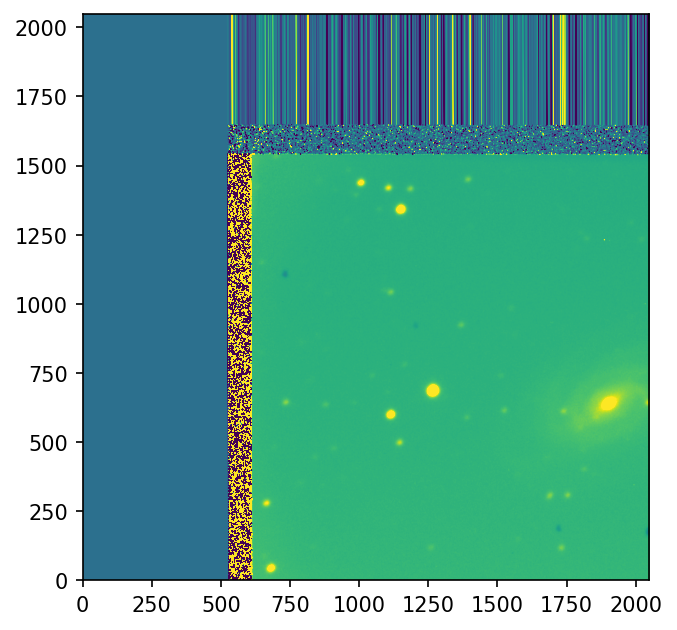

In [37]:
norm = ImageNormalize(data/2.0, interval=ZScaleInterval())
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=150)
ax.imshow(data,origin='lower',norm=norm)

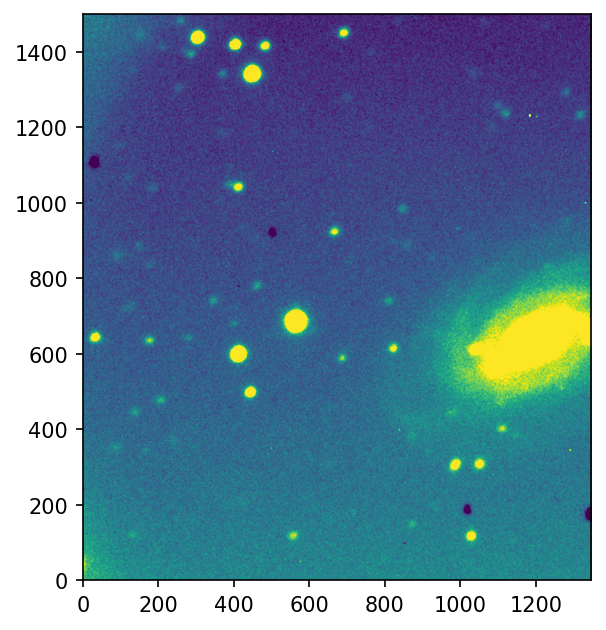

In [38]:
d = data[:1500,700:]
norm = ImageNormalize(d, interval=ZScaleInterval())
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=150)
ax.imshow(d,origin='lower',norm=norm)

In [39]:
hdulist = fits.open(fitsfile)
hdulist[0].data = d
hdulist[0].header = fits.getheader(wcsfile)
hdulist.writeto(cutout,overwrite=True)

In [67]:
SOLVE = "/Users/sasada/src/astrometry/bin/solve-field"
SE = "/opt/local/bin/sex"
SWARP = "/opt/local/bin/swarp"
HOTPANTS = "/Users/sasada/bin/hotpants"

h = fits.getheader(cutout)
res = ( np.sqrt( h["CD1_1"]**2 + h["CD1_2"]**2 ) + np.sqrt( h["CD2_1"]**2 + h["CD2_2"]**2 ) ) / 2.0
L, H = res * 0.9, res * 1.1
ra, dec = h["CRVAL1"], h["CRVAL2"]




In [34]:
command, cmd = [], []
cmd.append("{} ".format(SOLVE))
cmd.append("--cpulimit 60 --use-sextractor --sextractor-path {0} ".format(SE))
cmd.append("--scale-units dw --ra {0} --dec {1} --radius 1.0 ".format(str(ra),str(dec)))
cmd.append("--scale-low {0} --scale-high {1} ".format(str(L),str(U)))
cmd.append("--no-plots --out output --overwrite {0} ".format(cutout))
command.append("".join(cmd))
print(command[0])                                                                                                                                        
proc = subprocess.run(command[0], shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
if os.path.exists("output.solved"):
  shutil.copy("output.new","temp.fits")
LIST = glob.glob("output*")
for f in LIST:
  os.remove(f)


/Users/sasada/src/astrometry/bin/solve-field --cpulimit 60 --use-sextractor --sextractor-path /opt/local/bin/sex --scale-units dw --ra 148.616667 --dec -25.703639 --radius 1.0 --scale-low 6.189536031441783e-05 --scale-high 7.56498848287329e-05 --no-plots --out output --overwrite 20220225_i1_al_cutout.fits 


### Cannot solve WCS of cutout fits image. I used Astrometry.net. After solving, I used swarp and made coadd.fits.
### Using coadd.fits, I cutout the image, and subtract to the downloaded PS1 image. 

In [44]:
from astropy.nddata import Cutout2D

hdu = fits.open("coadd.fits")[0]
position = (1600,750)
size = (1000,1000)
wcs = WCS("coadd.fits")

cut = Cutout2D(hdu.data, position=position, size=size, wcs=wcs)

hdu.data = cut.data

hdu.header.update(cut.wcs.to_header())

hdu.writeto("cutout.fits",overwrite=True)

/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-OBS to '2022-02-25' from MJD-OBS'.
  warnings.warn(


In [47]:
import get_PanSTARRS
def get_ps1(w,SIZE,filters="i",overwrite=False):
  ps1_pixelscale = 0.25
  cen_x, cen_y = w.pixel_shape[0] / 2,  w.pixel_shape[1] / 2
  RA, Dec = w.all_pix2world(cen_x,cen_y,1)
  RA, Dec = float(RA), float(Dec)
  pixelscale = np.sqrt(w.pixel_scale_matrix[0][0]**2+w.pixel_scale_matrix[0][1]**2) * 3600./2.
  X_max_minutes, Y_max_minutes = np.array(w.pixel_shape) * pixelscale / 60.
  SIZE = int(SIZE * 60 / ps1_pixelscale)
  url = get_PanSTARRS.geturl(ra=RA, dec=Dec, size=SIZE, filters=filters, format="fits", color=False)
  print(url)
  tag = '{:0>9.5f}{:0>+9.5f}_{:s}_{:d}'.format(RA, Dec, filters, SIZE).replace('.', '')
  fout = os.path.join(".", 'ps1_{:s}.fits'.format(tag))
  if overwrite == True or not os.path.exists(fout):
    fh = fits.open(url[0],cache=True)
    if os.path.exists(fout): os.remove(fout)
    fh.writeto(fout)
    print("  Save: {}".format(fout))
    fh.close()
  if os.path.exists(fout): 
    return fout
  else:
    print(" No File Saved")
    return None


In [49]:
SIZE = 3.5
w = WCS("cutout.fits")
fps1 = get_ps1(w,SIZE,filters="i",overwrite=False)

['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=148.64747318548714&dec=-25.700115392336414&size=840&format=fits&red=/rings.v3.skycell/0748/056/rings.v3.skycell.0748.056.stk.i.unconv.fits']
  Save: ./ps1_14864747-2570012_i_840.fits


In [51]:
def adjust_image(hdu1, hdu2, output="temp.fits", outref="temp2.fits", mask="mask.fits", mref="mref.fits"):
  array, footprint = reproject_exact(hdu1, hdu2.header)
  marray = copy.deepcopy(array)
  marray[np.isnan(array)] = 1
  marray[~np.isnan(array)] = 0
  marr_ref = copy.deepcopy(hdu2.data)
  marr_ref[~np.isnan(marr_ref)] = 0
  marr_ref[np.isnan(marr_ref)] = 1
  fits.writeto(mask,marray,hdu2.header,overwrite=True)
  fits.writeto(mref,marr_ref,hdu2.header,overwrite=True)
  fits.writeto(output, array, hdu2.header, overwrite=True)
  fits.writeto(outref, hdu2.data, hdu2.header, overwrite=True)
  if os.path.exists(output) and os.path.exists(outref):
    return output, outref, mask, mref
  else:
    return None, None, None, None

In [52]:
hdu1 = fits.open("cutout.fits")[0]
hdu2 = fits.open("ps1_14864747-2570012_i_840.fits")[0]
output, outref, mask, mref = adjust_image(hdu1, hdu2, output="temp.fits", outref="temp2.fits", mask="mask.fits", mref="mref.fits")

/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.py:501: FITSFixedWarning: PC001001= -1. 
this form of the PCi_ja keyword is deprecated, use PCi_ja.
  wcsprm = _wcs.Wcsprm(header=header_bytes, key=key,
/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.py:501: FITSFixedWarning: PC001002= 0. 
this form of the PCi_ja keyword is deprecated, use PCi_ja.
  wcsprm = _wcs.Wcsprm(header=header_bytes, key=key,
/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.py:501: FITSFixedWarning: PC002001= 0. 
this form of the PCi_ja keyword is deprecated, use PCi_ja.
  wcsprm = _wcs.Wcsprm(header=header_bytes, key=key,
/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.py:501: FITSFixedWarning: PC002002= 1. 
this form of the PCi_ja keyword is deprecated, use PCi_ja.
  wcsprm = _wcs.Wcsprm(header=header_bytes, key=key,
/Users/sasada/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/wcs/wcs.p

In [62]:
cps1 = "/Users/sasada/work/sextractor/ps1.sex"
ps1_pixelscale = 0.25
def ng_est(fitsfile, fref):
  cmd = "{} -c {} {}".format(SE,cps1,fref)
  proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  tab_ps1 = ascii.read("test.cat")
  os.remove("test.cat")
  fwhm_ps1, _, _ = sigma_clipped_stats(tab_ps1[tab_ps1["FLAGS"] == 0]["FWHM_IMAGE"])
  cmd = "{} -c {} {}".format(SE,cps1,fitsfile)
  proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  tab_in = ascii.read("test.cat")
  os.remove("test.cat")
  fwhm_in, _, _ = sigma_clipped_stats(tab_in[tab_in["FLAGS"] == 0]["FWHM_IMAGE"])
  # calculate pixel scale of input image
  h = fits.getheader(fitsfile)
  in_pixelscale = h["CDELT1"]
  fwhm_in = fwhm_in * in_pixelscale / ps1_pixelscale
  # calculate sigma_match
  sigma_match = np.sqrt((np.power(fwhm_in,2.0) - np.power(fwhm_ps1,2.0)) / (4*2*np.log(2)))
  ng = " -ng 3 6 {} 4 {} 2 {}".format(0.5*sigma_match,sigma_match,2.0*sigma_match)
  print("-ng: {}".format(ng))
  return ng

ng = ng_est(output, outref)

-ng:  -ng 3 6 nan 4 nan 2 nan


/var/folders/3y/m1zwlvpj4fxb5f9d6sr6_cqc0000gn/T/ipykernel_35052/1987174770.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_match = np.sqrt((np.power(fwhm_in,2.0) - np.power(fwhm_ps1,2.0)) / (4*2*np.log(2)))


In [64]:
def extract_para(fin = "temp.fits", fref = "temp2.fits"):
  array = fits.getdata(fin)
  nx, ny = array.shape
  # cutout 1/3 to 2/3 of entire region
  st, en = int(nx / 3.), int(nx * 2. / 3.)
  omax, omin = np.max(array[st:en, st:en]), np.min(array[st:en, st:en])
  ps1_array = fits.getdata(fref)
  rmax, rmin = np.nanmax(ps1_array[st:en, st:en]), np.nanmin(ps1_array[st:en, st:en])
  IU, IL, TU, TL = omax + 1000, omin - 500, rmax + 1000, rmin - 500
  return IU, IL, TU, TL

IU, IL, TU, TL = extract_para(fin = "temp.fits", fref = "temp2.fits")

In [70]:
def hotpants_sub(Input,Reference,output,gain=1.0,rnoi=0.0,mask="mask.fits",mref="mref.fits",iu=IU,il=IL,iuk=None,tu=TU,tl=TL,tuk=None,nsx=5,STR=None):
  if iuk == None: iuk = iu
  if tuk == None: tuk = tu
  command, cmd = [], []
  cmd.append("{} ".format(HOTPANTS))
  cmd.append("-inim {0} -tmplim {1} -outim {2} ".format(Input,Reference,output))  
  if os.path.exists(mask): cmd.append("-imi {0} ".format(mask)) 
  if os.path.exists(mref): cmd.append("-tmi {0} ".format(mref)) 
  cmd.append("-iu {0} -il {1} -iuk {2} -ig {3} -ir {4} ".format(str(iu),str(il),str(iuk),str(gain),str(rnoi)))
  cmd.append("-tu {0} -tl {1} -tuk {2} -tg 1.4 -tr 0.0 ".format(str(tu),str(tl),str(tuk)))
  cmd.append("-nsx {0} -nsy {0} -n i ".format(str(nsx)))
  if STR != None:
    cmd.append(STR)
  command.append("".join(cmd))
  print(command[0])
  proc = subprocess.run(command[0], shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  return proc.stderr.find("SUCCESS")
  #return True


In [74]:
hotpants_sub(Input="temp.fits",Reference="temp2.fits",output="output.fits")

/Users/sasada/bin/hotpants -inim temp.fits -tmplim temp2.fits -outim output.fits -imi mask.fits -tmi mref.fits -iu 1073.5937861542893 -il -514.6154834916933 -iuk 1073.5937861542893 -ig 1.0 -ir 0.0 -tu 90107.828125 -tl -1663.3109130859375 -tuk 90107.828125 -tg 1.4 -tr 0.0 -nsx 5 -nsy 5 -n i 


16815

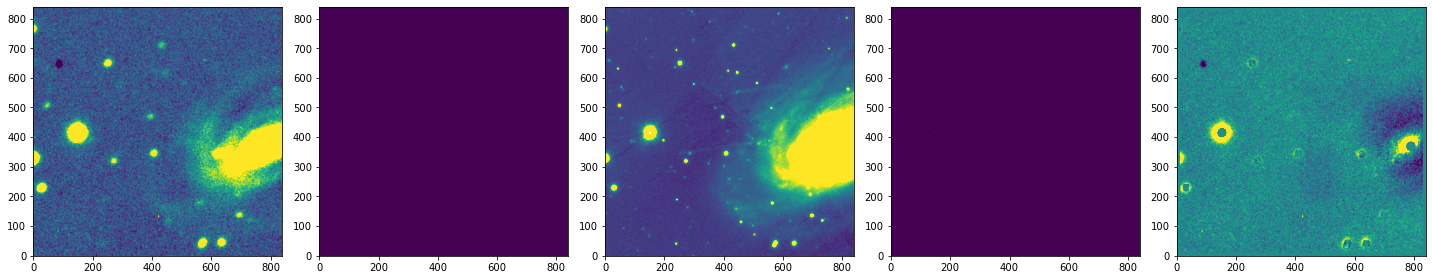

'output.pdf'

In [77]:
def plot_best(im_in, im_ref, im_out):
  # plot best subtracted image
  output = im_out.replace(".fits",".pdf")
  fig, ax = plt.subplots(1,5, figsize=(20,4), tight_layout=True)
  if os.path.exists(im_in) and os.path.exists(im_ref) and os.path.exists(im_out):
    data = fits.getdata(im_in)
    norm = ImageNormalize(data, interval=ZScaleInterval())
    ax[0].imshow(data,origin='lower',norm=norm)
    data = fits.getdata("mask.fits")
    ax[1].imshow(data,origin='lower')
    data = fits.getdata(im_ref)
    norm = ImageNormalize(data, interval=ZScaleInterval())
    ax[2].imshow(data,origin='lower',norm=norm)
    data = fits.getdata("mref.fits")
    ax[3].imshow(data,origin='lower')
    data = fits.getdata(im_out)
    norm = ImageNormalize(data, interval=ZScaleInterval())
    ax[4].imshow(data,origin='lower',norm=norm)
    if os.path.exists(output): os.remove(output)
    plt.savefig(output,bbox_inches="tight")
    plt.show()
    return output
  else:
    print("No best image is created.")
    return False
  
plot_best(im_in="temp.fits", im_ref="temp2.fits", im_out="output.fits")